In [1]:
!pip install imageio
#!pip install --upgrade tensorflow
!pip install pydot==2.0.0 --upgrade

In [1]:
# Import the required libraries.
import os
import cv2
# import pafy
import math
import random
import numpy as np
import datetime as dt
from collections import deque
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import imageio
import imgaug.augmenters as iaa
import imgaug as ia
import tensorflow as tf
import seaborn as sns

In [2]:
import tensorflow as tf

# Check TensorFlow version
print("TensorFlow version:", tf.__version__)

# Check if GPU is available
if tf.test.is_gpu_available():
    print("GPU is available")
else:
    print("GPU is NOT available")


TensorFlow version: 2.10.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU is available


In [3]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [4]:
seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)

['Accident', 'Normal']
[1, 0]
Normal
['13032018 Подборка ДТП 48 (ДТП авария происшествия car crash compilation dashcam_1307_1409.mp4', '13032018 Подборка ДТП 48 (ДТП авария происшествия car crash compilation dashcam_1664_1695.mp4', '13032018 Подборка ДТП 48 (ДТП авария происшествия car crash compilation dashcam_2164_2217.mp4', '13032018 Подборка ДТП 48 (ДТП авария происшествия car crash compilation dashcam_240_305.mp4', '13032018 Подборка ДТП 48 (ДТП авария происшествия car crash compilation dashcam_2421_2537.mp4', '13032018 Подборка ДТП 48 (ДТП авария происшествия car crash compilation dashcam_2721_2792.mp4', '13032018 Подборка ДТП 48 (ДТП авария происшествия car crash compilation dashcam_3061_3170.mp4', '13032018 Подборка ДТП 48 (ДТП авария происшествия car crash compilation dashcam_318_545.mp4', '13032018 Подборка ДТП 48 (ДТП авария происшествия car crash compilation dashcam_3378_3438.mp4', '13032018 Подборка ДТП 48 (ДТП авария происшествия car crash compilation dashcam_5150_5220.mp

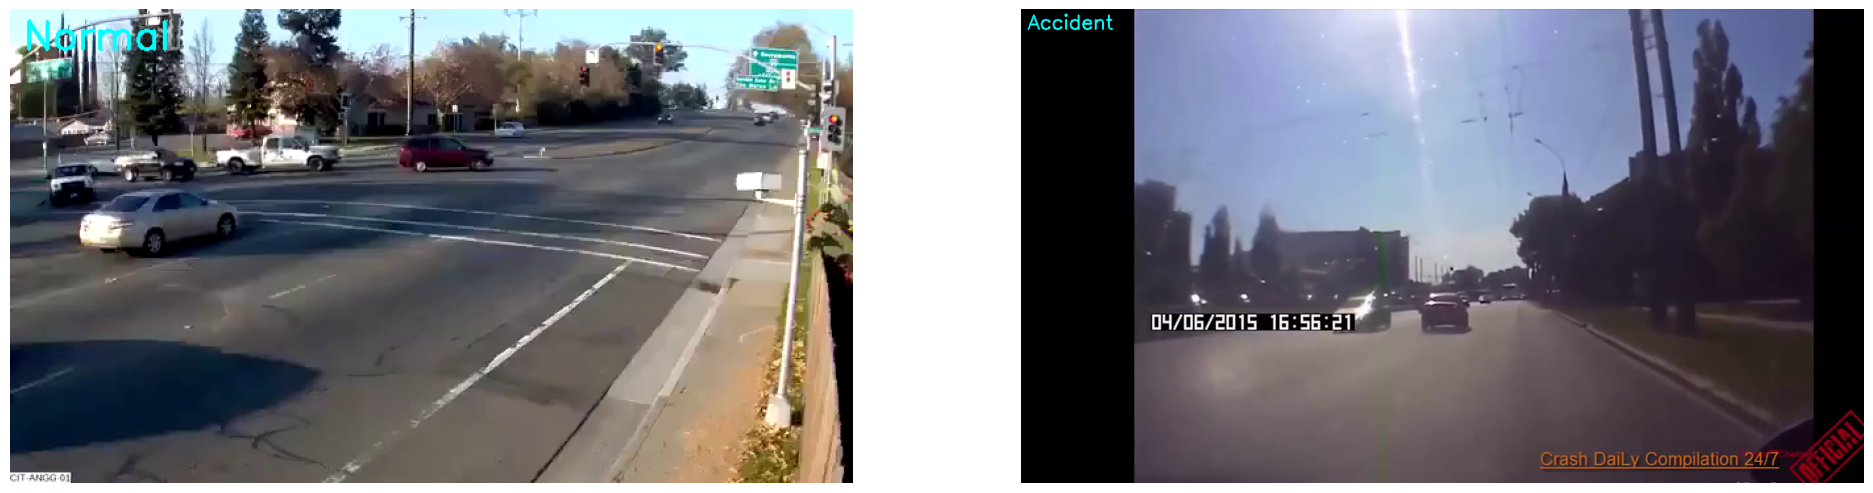

In [5]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (50,50 ))

# Get the names of all classes in dataset
all_classes_names = os.listdir('dataset')
print(all_classes_names)

random_range = random.sample(range(len(all_classes_names)), 2)
print(random_range)

# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]
    print(selected_class_Name)

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'dataset/{selected_class_Name}')
    print(video_files_names_list)

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)
    print(selected_video_file_name)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'dataset/{selected_class_Name}/{selected_video_file_name}')

    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object.
    video_reader.release()

    # Convert the frame from BGR into RGB format.
    # rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Convert the frame from BGR into RGB format.
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 255), 2)

    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [6]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 224, 224

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 15

# Specify the directory containing the UCF50 dataset.
DATASET_DIR = "dataset"

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ["Accident", "Normal"]
# /content/drive/MyDrive/MobileVnet2 Dataset/NonViolence

In [7]:
''' def frames_extraction(video_path):
    
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if video_frames_count > 0:
        print("Total Frame in video count", video_frames_count)

        #Calculate the the interval after which frames will be added to the list.
        skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
        print("skip_frames_window", skip_frames_window)

    # Iterate through the Video Frames.
        for frame_counter in range(SEQUENCE_LENGTH):

            # print(frame_counter)

            # Set the current frame position of the video.
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

            # Reading the frame from the video.
            success, frame = video_reader.read()

            zoom = iaa.Affine(scale=1.3)
            random_brightness = iaa.Multiply((1, 1.3))
            #rotate = iaa.Affine(rotate=(-25, 25))

            #image_aug = flip(image = image)
            #image_aug = random_brightness(image = frame)
            image_aug = zoom(image = frame)
            #image_aug = rotate(image = image_aug)



            # Check if Video frame is not successfully read then break the loop
            if not success:
                break

            # Resize the Frame to fixed height and width.
            resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
            # cv2_imshow(resized_frame)

            # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
            normalized_frame = resized_frame / 255

            # Append the normalized frame into the frames list
            frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list '''

' def frames_extraction(video_path):\n    \n    This function will extract the required frames from a video after resizing and normalizing them.\n    Args:\n        video_path: The path of the video in the disk, whose frames are to be extracted.\n    Returns:\n        frames_list: A list containing the resized and normalized frames of the video.\n    \n\n    # Declare a list to store video frames.\n    frames_list = []\n\n    # Read the Video File using the VideoCapture object.\n    video_reader = cv2.VideoCapture(video_path)\n\n    # Get the total number of frames in the video.\n    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))\n    \n    if video_frames_count > 0:\n        print("Total Frame in video count", video_frames_count)\n\n        #Calculate the the interval after which frames will be added to the list.\n        skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)\n        print("skip_frames_window", skip_frames_window)\n\n    # Iterate 

=====Test====

In [8]:
'''import cv2
import numpy as np
from imgaug import augmenters as iaa

def frames_extraction(video_path):
    
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    

    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)
    
    # Check if the video was opened successfully
    if not video_reader.isOpened():
        print(f"Error: Could not open video {video_path}")
        return frames_list

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if video_frames_count > 0:
        print("Total Frame in video count:", video_frames_count)

        # Calculate the interval after which frames will be added to the list.
        skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)
        print("skip_frames_window:", skip_frames_window)

        # Iterate through the Video Frames.
        for frame_counter in range(SEQUENCE_LENGTH):
            # Set the current frame position of the video.
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

            # Reading the frame from the video.
            success, frame = video_reader.read()

            if not success:
                print(f"Warning: Frame {frame_counter} could not be read.")
                continue

            # Apply transformations
            zoom = iaa.Affine(scale=(1, 1.3))
            random_brightness = iaa.Multiply((1, 1.3))
            rotate = iaa.Affine(rotate=(-25, 25))
            
            
            
            # Perform augmentation
            frame = zoom(image=frame)
            frame = random_brightness(image=frame)
            #frame = rotate(image = frame)
            
            # Check if the frame is None after augmentation
            if frame is None:
                print(f"Warning: Frame {frame_counter} is None after augmentation.")
                continue

            # Resize the Frame to fixed height and width.
            resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

            # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
            normalized_frame = resized_frame / 255.0

            # Append the normalized frame into the frames list
            frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list '''


'import cv2\nimport numpy as np\nfrom imgaug import augmenters as iaa\n\ndef frames_extraction(video_path):\n    \n    This function will extract the required frames from a video after resizing and normalizing them.\n    Args:\n        video_path: The path of the video in the disk, whose frames are to be extracted.\n    Returns:\n        frames_list: A list containing the resized and normalized frames of the video.\n    \n\n    frames_list = []\n\n    # Read the Video File using the VideoCapture object.\n    video_reader = cv2.VideoCapture(video_path)\n    \n    # Check if the video was opened successfully\n    if not video_reader.isOpened():\n        print(f"Error: Could not open video {video_path}")\n        return frames_list\n\n    # Get the total number of frames in the video.\n    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))\n    \n    if video_frames_count > 0:\n        print("Total Frame in video count:", video_frames_count)\n\n        # Calculate the in

====Test====

In [9]:
import cv2
import numpy as np
from imgaug import augmenters as iaa

def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)
    
    # Check if the video was opened successfully
    if not video_reader.isOpened():
        print(f"Error: Could not open video {video_path}")
        return frames_list

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    
    if video_frames_count > 0:
        print("Total Frame in video count:", video_frames_count)

        # Calculate the interval after which frames will be added to the list.
        skip_frames_window = max(int(video_frames_count / SEQUENCE_LENGTH), 1)
        print("skip_frames_window:", skip_frames_window)

        # Define the augmentation sequence
        seq = iaa.Sequential([
            iaa.Affine(scale=(0.8, 1.2)),    # Random scaling
            iaa.Affine(rotate=(-25, 25)),    # Random rotation
            #iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)}),  # Random translation
            iaa.Multiply((0.7, 1.3)),        # Random brightness
            #iaa.GaussianBlur(sigma=(0.0, 3.0)), # Random Gaussian blur
            iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),  # Random noise addition
            #iaa.ContrastNormalization((0.5, 1.5)),  # Random contrast adjustment
            #iaa.Fliplr(0.5),                  # Random horizontal flip
            iaa.Crop(percent=(0, 0.2))        # Random cropping
        ])

        # Iterate through the Video Frames.
        for frame_counter in range(SEQUENCE_LENGTH):
            # Set the current frame position of the video.
            video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

            # Reading the frame from the video.
            success, frame = video_reader.read()

            if not success:
                print(f"Warning: Frame {frame_counter} could not be read.")
                continue

            # Perform augmentation
            frame = seq(image=frame)

            # Check if the frame is None after augmentation
            if frame is None:
                print(f"Warning: Frame {frame_counter} is None after augmentation.")
                continue

            # Resize the Frame to fixed height and width.
            resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

            # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
            normalized_frame = resized_frame / 255.0

            # Append the normalized frame into the frames list
            frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list


In [10]:
def create_dataset():
    i = 0
    '''
    This function will extract the data of the selected classes and create the required dataset.
    Returns:
        features:          A list containing the extracted frames of the videos.
        labels:            A list containing the indexes of the classes associated with the videos.
        video_files_paths: A list containing the paths of the videos in the disk.
    '''

    # Declared Empty Lists to store the features, labels and video file path values.
    features = []
    labels = []
    video_files_paths = []

    # Iterating through all the classes mentioned in the classes list
    print(CLASSES_LIST)
    for class_index, class_name in enumerate(CLASSES_LIST):

        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')

        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        # print(files_list)
        files_list= files_list[:200]
        print(len(files_list))
        np.random.shuffle(files_list)

        # Iterate through all the files present in the files list.
        for file_name in files_list:
            print(i)

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == SEQUENCE_LENGTH:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
                i = i+1
                if i == 999:
                  i = 0

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)

    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [11]:
features, labels, video_file_path = create_dataset()

['Accident', 'Normal']
Extracting Data of Class: Accident
200
0
Total Frame in video count: 151
skip_frames_window: 10
1
Total Frame in video count: 162
skip_frames_window: 10
2
Total Frame in video count: 93
skip_frames_window: 6
3
Total Frame in video count: 153
skip_frames_window: 10
4
Total Frame in video count: 173
skip_frames_window: 11
5
Total Frame in video count: 149
skip_frames_window: 9


KeyboardInterrupt: 

In [236]:
np.save("features.npy", features)
np.save("labels.npy", labels)
np.save("video_files_paths.npy", video_file_path)

In [237]:
# # Using Keras's to_categorical method to convert labels into one-hot-encoded vectors
one_hot_encoded_labels = to_categorical(labels)
# print(one_hot_encoded_labels)

In [238]:
features, labels, video_files_paths = np.load("features.npy") , np.load("labels.npy") ,  np.load("video_files_paths.npy")

In [239]:
# Split the Data into Train ( 75% ) and Test Set ( 25% ).
features_train, features_test, labels_train, labels_test = train_test_split(features, labels,test_size = 0.25, shuffle = True,random_state = seed_constant)

In [240]:
print(features_train.shape,labels_train.shape )
print(features_test.shape, labels_test.shape)

(298, 15, 224, 224, 3) (298,)
(100, 15, 224, 224, 3) (100,)


In [241]:
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [242]:
from keras.applications.mobilenet_v2 import MobileNetV2
my_model = MobileNetV2(include_top = False , weights="imagenet")

#Fine-Tuning to make the last 40 layer trainable
my_model.trainable = False

my_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_16[0][0]']               
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                            

In [243]:
def create_model():

    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)
    optimizers = tf.keras.optimizers

    model = Sequential([

    ########################################################################################################################

    #Specifying Input to match features shape
    Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)),

    # Passing mobilenet in the TimeDistributed layer to handle the sequence
    TimeDistributed(my_model),
    Dropout(0.2),
    # Time distributed
    TimeDistributed(Flatten()),

    Bidirectional(lstm_fw, backward_layer = lstm_bw),
    Dropout(0.2),
        # Layer 1
    Dense(256,activation='relu'),
    Dropout(0.2),
    Dense(128,activation='relu'),
    Dropout(0.2),
        # Layer 3
    Dense(64,activation='relu'),
    Dropout(0.2),
        #  Layer 4
    Dense(32,activation='relu'),
    Dropout(0.2),
        # #Layer 1
        # softmax
    Dense(len(CLASSES_LIST), activation = 'sigmoid')
    ])

    adam = optimizers.Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(loss="binary_crossentropy", optimizer=adam, metrics=["accuracy"])
    # Compiling the model
    #model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])
    ########################################################################################################################

    model.summary()

    return model

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 15, 7, 7, 1280)   2257984   
 stributed)                                                      
                                                                 
 dropout_48 (Dropout)        (None, 15, 7, 7, 1280)    0         
                                                                 
 time_distributed_17 (TimeDi  (None, 15, 62720)        0         
 stributed)                                                      
                                                                 
 bidirectional_8 (Bidirectio  (None, 64)               16064768  
 nal)                                                            
                                                                 
 dropout_49 (Dropout)        (None, 64)                0         
                                                      

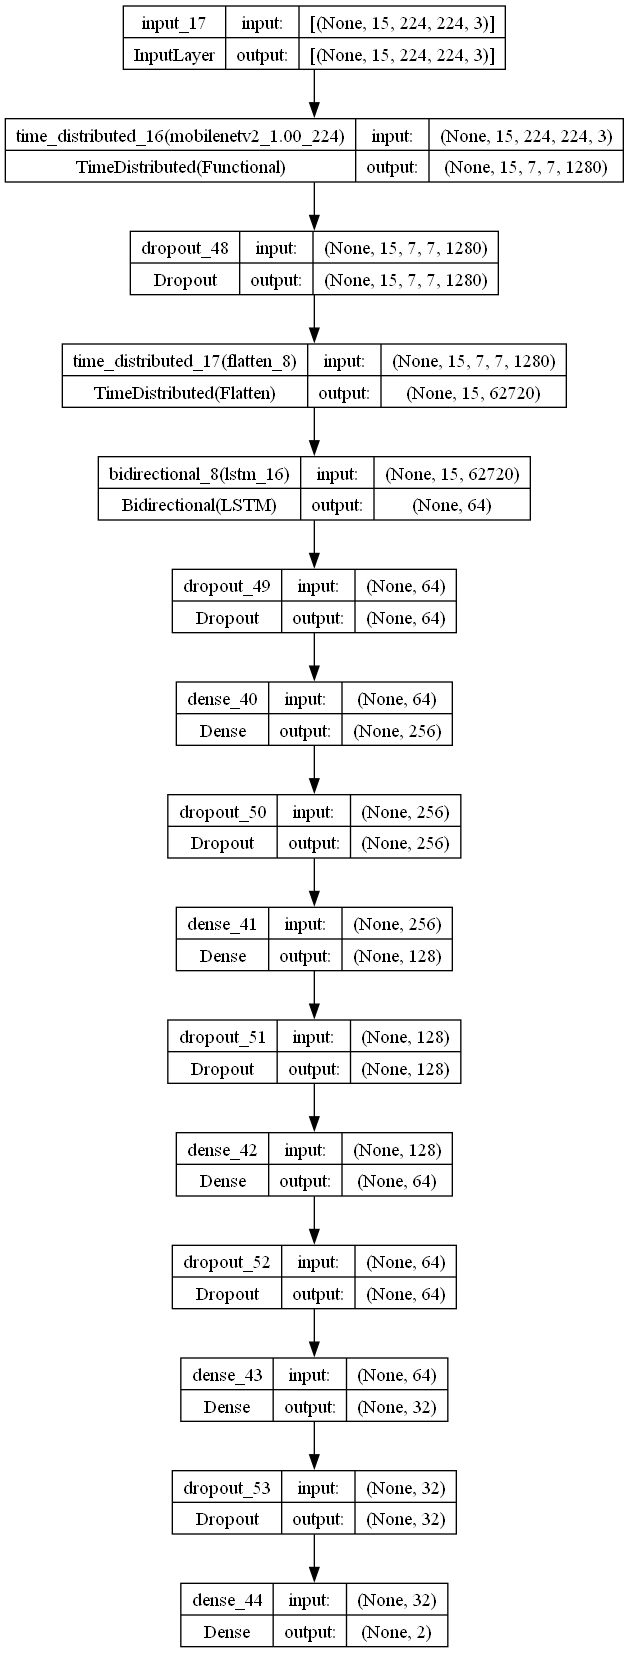

In [244]:
# Constructing the Model
my_LSTM_model = create_model()

# Plot the structure of the contructed LRCN model.
plot_model(my_LSTM_model, to_file = 'my_LSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [245]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau
patience = 5

start_lr = 0.0001
min_lr = 0.0001
max_lr = 0.005

batch_size = 4
rampup_epochs = 5
sustain_epochs = 0
exp_decay = .8

def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr)/rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch-rampup_epochs-sustain_epochs) + min_lr


lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=False)


In [246]:
# Create Early Stopping Callback to monitor the accuracy
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy',
                                        patience = 5, restore_best_weights=True)

# Create checkpoint for model
# Change name for model

checkpoint_filepath = 'ModelWeights.h5'

model_checkpoints = ModelCheckpoint(filepath=checkpoint_filepath,
                                        save_weights_only=True,
                                        monitor='val_loss',
                                        mode='min',
                                        verbose = 1,
                                        save_best_only=True)

# Create ReduceLROnPlateau Callback to reduce overfitting by decreasing learning
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.8,
                                                  patience=3,
                                                  min_lr=0.00001,
                                                  verbose=1)
callbacks = [lr_callback, early_stopping_callback, reduce_lr]

In [247]:
from sklearn.preprocessing import OneHotEncoder

# Create an instance of OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Reshape labels_train if necessary (assuming it has shape (4,))
labels_train = labels_train.reshape((-1, 1))

# Fit and transform labels_train
labels_train_encoded = encoder.fit_transform(labels_train)

# Verify the shape of labels_train_encoded
print("Shape of labels_train_encoded:", labels_train_encoded.shape)

Shape of labels_train_encoded: (298, 2)


In [248]:
labels_train_encoded

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.

In [249]:
# Fitting the model
from tensorflow.keras.callbacks import ModelCheckpoint

#checkpoint = ModelCheckpoint('model.h5', save_best_only=True, monitor='val_loss', mode='min')

my_LSTM_model_history = my_LSTM_model.fit(x = features_train, y = labels_train_encoded, epochs = 50, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2)
# , callbacks = callbacks

Epoch 1/50
30/30 [==============================] - 15s 207ms/step - loss: 0.7102 - accuracy: 0.4538 - val_loss: 0.6941 - val_accuracy: 0.5000
Epoch 2/50
30/30 [==============================] - 3s 104ms/step - loss: 0.7009 - accuracy: 0.4916 - val_loss: 0.6943 - val_accuracy: 0.4833
Epoch 3/50
30/30 [==============================] - 3s 107ms/step - loss: 0.6976 - accuracy: 0.4790 - val_loss: 0.6933 - val_accuracy: 0.4833
Epoch 4/50
30/30 [==============================] - 3s 108ms/step - loss: 0.6950 - accuracy: 0.4790 - val_loss: 0.6932 - val_accuracy: 0.4667
Epoch 5/50
30/30 [==============================] - 3s 107ms/step - loss: 0.6926 - accuracy: 0.5210 - val_loss: 0.6941 - val_accuracy: 0.4833
Epoch 6/50
30/30 [==============================] - 3s 108ms/step - loss: 0.6955 - accuracy: 0.5420 - val_loss: 0.6934 - val_accuracy: 0.5167
Epoch 7/50
30/30 [==============================] - 3s 109ms/step - loss: 0.6928 - accuracy: 0.5252 - val_loss: 0.6926 - val_accuracy: 0.5167
Epoch

In [250]:
from sklearn.preprocessing import OneHotEncoder

# Create an instance of OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)

# Reshape labels_train if necessary (assuming it has shape (4,))
labels_test = labels_test.reshape((-1, 1))

# Fit and transform labels_train
labels_test = encoder.fit_transform(labels_test)

# Verify the shape of labels_train_encoded
print("Shape of labels_test_encoded:", labels_test.shape)
print("Shape of labels_train_encoded:", labels_train.shape)

Shape of labels_test_encoded: (100, 2)
Shape of labels_train_encoded: (298, 1)


In [251]:
model_evaluation_history = my_LSTM_model.evaluate(features_test, labels_test)

4/4 [==============================] - 1s 185ms/step - loss: 0.6933 - accuracy: 0.4900


In [252]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Get the Epochs Count
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

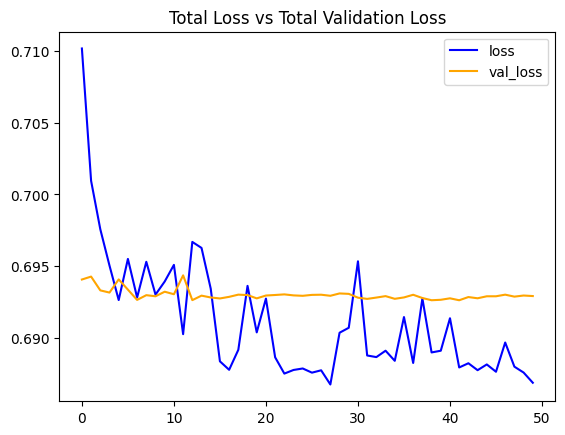

In [253]:
plot_metric(my_LSTM_model_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

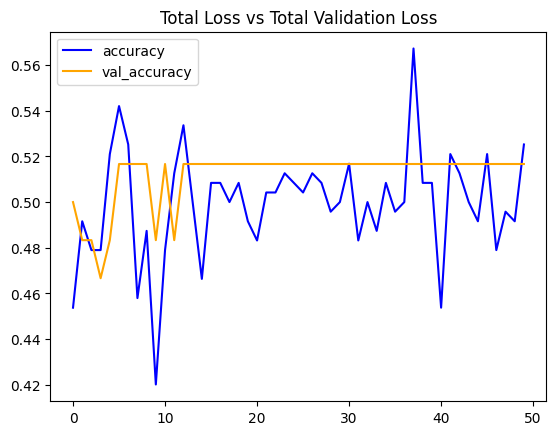

In [254]:
plot_metric(my_LSTM_model_history, 'accuracy', 'val_accuracy', 'Total Loss vs Total Validation Loss')

In [255]:
labels_predict = my_LSTM_model.predict(features_test)

4/4 [==============================] - 3s 181ms/step


In [217]:
# Decoding the data to use in Metrics
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(labels_test , axis=1)

In [218]:
labels_test_normal.shape , labels_predict.shape

((100,), (100,))

In [219]:
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.49


In [220]:
!pip install seaborn

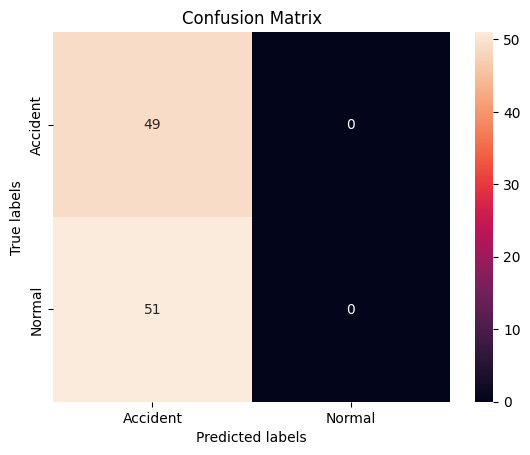

In [221]:

from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Accident',"Normal"]); ax.yaxis.set_ticklabels(['Accident',"Normal"]);

In [222]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.49      1.00      0.66        49
           1       0.00      0.00      0.00        51

    accuracy                           0.49       100
   macro avg       0.24      0.50      0.33       100
weighted avg       0.24      0.49      0.32       100



d:\Anaconda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Anaconda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Anaconda\envs\tf\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [156]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

# Define the string date format.
# Get the current Date and Time in a DateTime Object.
# Convert the DateTime object to string according to the style mentioned in date_time_format string.
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

# Define a useful name for our model to make it easy for us while navigating through multiple saved models.
model_file_name = f'convlstm_model___Date_Time_{current_date_time_string}___Loss_{model_evaluation_loss}___Accuracy_{model_evaluation_accuracy}.h5'

# Save your Model.
my_LSTM_model.save(model_file_name)

iNFERENCE

In [42]:
i = 0

In [167]:
import cv2
import numpy as np
import tensorflow as tf

# Load your trained model
model = tf.keras.models.load_model('convlstm_model___Date_Time_2024_07_19__13_37_43___Loss_1.3894158601760864___Accuracy_0.6800000071525574.h5')

# Open the video file
video_path = 'dataset/Accident/Accidents from first 2011 snow in Overland Park KS_2857_3146.mp4'
cap = cv2.VideoCapture(video_path)

# Check if the video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get video properties
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fourcc = cv2.VideoWriter_fourcc(*'XVID')
# Define a useful name for our model to make it easy for us while navigating through multiple saved models.


video_name = f'Video.avi'
out = cv2.VideoWriter(video_name, fourcc, fps, (width, height))

# Parameters
sequence_length = 15  # Adjust this according to your model's expected sequence length
frames = []

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame (adjust this part according to your model's input requirements)
    preprocessed_frame = cv2.resize(frame, (224, 224))  # Example size
    preprocessed_frame = preprocessed_frame / 255.0  # Normalize if needed
    frames.append(preprocessed_frame)

    # If we have enough frames, make a prediction
    if len(frames) == sequence_length:
        input_sequence = np.array(frames)
        input_sequence = np.expand_dims(input_sequence, axis=0)  # Add batch dimension

        # Make predictions
        predictions = model.predict(input_sequence)

        # Post-process the predictions (adjust according to your model's output)
        label = np.argmax(predictions, axis=1)[0]  # Example for classification

        # Display the label on the frame
        cv2.putText(frame, str(label), (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        # Write the frame to the output video
        out.write(frame)

        # Clear the frames list to process the next sequence
        frames = []

    # Display the frame (optional)
    cv2.imshow('Frame', frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    


# Release everything if job is finished
cap.release()
out.release()
cv2.destroyAllWindows()


1/1 [==============================] - 0s 54ms/step
